In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import joblib 
import warnings

# Ignore useless warnings
warnings.filterwarnings('ignore')  

In [2]:
# Paths
PATH_TO_TRAIN = 'dataset/train.txt'
MODEL_NAME = 'RUL_biLSTM_R.pth'

SEED = 112233

# Data preprocessing parameters
SEQUENCE_LENGTH = 128       # Sequence length
TEST_SIZE = 0.2             # Proportion of data for validation
RANDOM_STATE = 42           # Random state for reproducibility

# Model parameters
LSTM_HIDDEN_SIZE1 = 350  # Hidden size of the first LSTM layer
LSTM_HIDDEN_SIZE2 = 150  # Hidden size of the second LSTM layer
LSTM_NUM_LAYERS = 5      # Number of layers in LSTM
DROPOUT = 0.3            # Dropout rate for regularization

# Training parameters
BATCH_SIZE = 256       # Batch size
LEARNING_RATE = 0.001  # Learning rate
WEIGHT_DECAY = 1e-5    # L2 regularization coefficient
NUM_EPOCHS = 100       # Maximum number of training epochs
PATIENCE = 10          # Number of epochs without improvement for early stopping
CLIP_GRAD = 5.0        # Parameter for gradient clipping

In [3]:
# Setting up the computing device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed):
    np.random.seed(seed)  # Setting seed for numpy
    torch.manual_seed(seed)  # Setting seed for torch
    torch.cuda.manual_seed_all(seed)  # Setting seed for all GPUs

Using device: cuda


In [4]:
# Step 1: Data Loading
train_df = pd.read_csv(PATH_TO_TRAIN, sep=' ', header=None)

# Remove columns with missing values
train_df.dropna(axis=1, inplace=True) 

In [5]:
# Assign column names based on description 
columns = ['unit_number', 'time_in_cycles']  # Engine number and number of cycles
columns += ['op_setting_1', 'op_setting_2', 'op_setting_3']  
sensor_cols = ['sensor_measurement_{}'.format(i) for i in range(1, 22)]  
columns += sensor_cols  

train_df.columns = columns  # Assign names to columns

In [6]:
# Counting the number of engines
num_engines = train_df['unit_number'].nunique()
print(f"Number of engines: {num_engines}")

Number of engines: 218


##### Calculating RUL (Remaining Useful Life)

In [7]:
# Find the maximum number of cycles for each engine
rul = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()  # Grouping by engine number and finding maximum cycle

rul.columns = ['unit_number', 'max_cycle']  # Create temporary cycle column

In [8]:
# Calculate RUL for each time point
train_df = train_df.merge(rul, on='unit_number', how='left')  # Merge with maximum cycle
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']  # Calculate RUL

# Remove temporary 'max_cycle' column
train_df.drop('max_cycle', axis=1, inplace=True) 

#### Data Preprocessing

In [9]:
# Remove uninformative sensors based on conclusions in 'data_analysis' file
cols_to_drop = ['sensor_measurement_13', 'sensor_measurement_16', 'sensor_measurement_19']

In [10]:
# Form the list of features
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [col for col in sensor_cols if col not in cols_to_drop]

In [11]:
# Target variable
target_col = ['RUL']  

# Update INPUT_SIZE according to the number of features
INPUT_SIZE = len(feature_cols)  

In [12]:
# Split data into training and validation sets by engines
unit_numbers = train_df['unit_number'].unique()  
unit_train, unit_valid = train_test_split(unit_numbers, test_size=TEST_SIZE, random_state=RANDOM_STATE) 

Splitting by engines rather than individual records prevents information leakage between training and validation, which can lead to overestimating model performance.

In [13]:
train_df_train = train_df[train_df['unit_number'].isin(unit_train)].copy()  
train_df_valid = train_df[train_df['unit_number'].isin(unit_valid)].copy()  

print(f"Number of engines in training set: {train_df_train['unit_number'].nunique()}")
print(f"Number of engines in validation set: {train_df_valid['unit_number'].nunique()}")

Number of engines in training set: 174
Number of engines in validation set: 44


##### Data Normalization

In [14]:
scaler_X = StandardScaler()  # Scaler for features
scaler_Y = StandardScaler()  # Scaler for target variable

Data are normalized using StandardScaler to bring features and the target variable to a standard normal distribution with zero mean and unit variance.

In [15]:
# If needed for another dataset
# train_df_train = train_df_train.dropna(subset=target_col)  
# train_df_valid = train_df_valid.dropna(subset=target_col)  

In [16]:
# Train scalers on training data
scaler_X.fit(train_df_train[feature_cols]) 
scaler_Y.fit(train_df_train[target_col])    

StandardScaler()

In [17]:
# Apply scalers to training and validation data
train_df_train[feature_cols] = scaler_X.transform(train_df_train[feature_cols])  
train_df_valid[feature_cols] = scaler_X.transform(train_df_valid[feature_cols]) 

train_df_train[target_col] = scaler_Y.transform(train_df_train[target_col])  
train_df_valid[target_col] = scaler_Y.transform(train_df_valid[target_col])  

In [18]:
# Save scalers for later use on test data
joblib.dump(scaler_X, 'model_scalers/scaler_X.pkl')  
joblib.dump(scaler_Y, 'model_scalers/scaler_Y.pkl')  

['model_scalers/scaler_Y.pkl']

#### Generating Sequences with Sliding Windows

In [19]:
def gen_sequence_sliding(id_df, seq_length, seq_cols, label_col):
    """
    Generates fixed-length sequences for one engine using sliding windows.
    Returns lists of sequences, corresponding labels, and masks.
    """
    data_array = id_df[seq_cols].values  # Feature array
    rul_array = id_df[label_col].values  # Target variable array
    num_elements = data_array.shape[0]   # Number of cycles
    
    seq_list = []    # List for sequences
    label_list = []  # List for labels
    mask_list = []   # List for masks
    
    if num_elements >= seq_length:
        # Generate sliding windows
        for start in range(num_elements - seq_length):
            seq = data_array[start:start + seq_length, :]
            seq_list.append(seq)
            label_list.append(rul_array[start + seq_length])  # Label for the sequence
            mask_list.append(np.ones(seq_length, dtype=np.float32))  # Mask: all data are valid
    else:
        # Pad sequence to required length
        pad_length = seq_length - num_elements
        padded_seq = np.pad(data_array, ((pad_length, 0), (0, 0)), 'constant', constant_values=0)
        seq_list.append(padded_seq)
        label_list.append(rul_array[-1])  # Use the last RUL value
        mask = np.concatenate([np.zeros(pad_length, dtype=np.float32), np.ones(num_elements, dtype=np.float32)])
        mask_list.append(mask)
    
    return seq_list, label_list, mask_list

To model temporal dependencies in the data, the sliding window method with sequence length SEQUENCE_LENGTH is used. If the number of available cycles for an engine is less than the sequence length, padding with zeros at the beginning of the sequence is applied. Masks are used to indicate valid data in the sequence, allowing the model to ignore padded values.

In [20]:
def generate_sequences_and_labels(dataframe, sequence_length, feature_columns, target_column):
    """
    Generates sequences, labels, and masks for training and validation sets.
    
    Parameters:
    dataframe (DataFrame): Data containing engine information.
    sequence_length (int): Sequence length for generation.
    feature_columns (list): List of feature column names.
    target_column (str): Name of the label (target variable) column.
    
    Returns:
    tuple: Arrays of sequences, labels, masks, and engine numbers.
    """
    sequences = []  # List to store sequences
    labels = []     # List to store labels
    masks = []      # List to store masks
    engines = []    # List to store engine numbers
    
     # Iterate over all unique engines
    for engine_id in dataframe['unit_number'].unique(): 
        engine_data = dataframe[dataframe['unit_number'] == engine_id]  # Filter data for a specific engine
        seq_gen, label_gen, mask_gen = gen_sequence_sliding(engine_data, sequence_length, feature_columns, target_column)  # Generate sequences, labels, and masks
        if seq_gen:
            sequences.extend(seq_gen)  
            labels.extend(label_gen)   
            masks.extend(mask_gen)     
            engines.extend([engine_id] * len(seq_gen)) 

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    labels = np.array(labels).astype(np.float32)
    masks = np.array(masks).astype(np.float32)
    engines = np.array(engines)

    print(f"Generated sequences: {len(sequences)}")
    return sequences, labels, masks, engines

In [21]:
# Generate sequences, labels, and masks for training set
seq_array_train, label_array_train, mask_array_train, engine_train = generate_sequences_and_labels(train_df_train, SEQUENCE_LENGTH, feature_cols, target_col[0])
# Generate sequences, labels, and masks for validation set
seq_array_valid, label_array_valid, mask_array_valid, engine_valid = generate_sequences_and_labels(train_df_valid, SEQUENCE_LENGTH, feature_cols, target_col[0])


Generated sequences: 14148
Generated sequences: 3866


#### Creating Datasets and Data Loaders

In [22]:
class TurbofanDataset(Dataset):
    def __init__(self, sequences, labels, masks, engines):
        self.sequences = sequences  # Store sequences
        self.labels = labels        # Store labels
        self.masks = masks          # Store masks
        self.engines = engines      # Store engine numbers

    def __len__(self):
        return len(self.sequences)  

    def __getitem__(self, idx):
        # Convert to float32 for sequences, masks, and labels
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)  
        label = torch.tensor(self.labels[idx], dtype=torch.float32)        
        mask = torch.tensor(self.masks[idx], dtype=torch.float32)         
        engine = self.engines[idx]   
        return sequence, label, mask, engine  


In [23]:
# Create Datasets with masks
train_dataset = TurbofanDataset(seq_array_train, label_array_train, mask_array_train, engine_train)  
valid_dataset = TurbofanDataset(seq_array_valid, label_array_valid, mask_array_valid, engine_valid)  

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          drop_last=False)  
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False)  

print(f"Datasets and data loaders created with masks.") 

Datasets and data loaders created with masks.


#### Model Definition 

The choice of this architecture is due to the need for effectively extracting both spatial and temporal dependencies from multivariate time series obtained from sensors.

*Convolutional Neural Networks (CNNs) are used to capture local patterns and spatial features in the data, which is especially useful when working with sensor data where some sensors may be correlated with each other.*

*Bidirectional LSTM layers allow the model to capture both past and future dependencies in the sequence, which is important for RUL prediction, considering the temporal dynamics of engine degradation.*

According to the survey **"Remaining Useful Life Prediction Based on Deep Learning: A Survey"**, combined CNN-LSTM models have proven effective in RUL prediction tasks:

> *"CNN-LSTM models have been successfully applied in RUL prediction tasks, where CNN layers are used to extract local features, and LSTM layers to capture temporal dependencies."*

Alternative approaches, such as using only LSTM or only CNN, may not provide the same level of performance due to limitations in extracting either local or long-term features.

It might be debatable that I am using three bi-directional LSTM layers with relatively large hidden sizes (`lstm_hidden_size1=350`, `lstm_hidden_size2=150`, `lstm_num_layers=4`). However, I did not observe overfitting, and the training time is acceptable (a few minutes), so I decided to keep this configuration due to its effectiveness.

In [24]:
class TurbofanModel(nn.Module):
    def __init__(self, input_size, dropout=0.3, lstm_hidden_size1=350, lstm_hidden_size2=150, lstm_num_layers=4):
        super(TurbofanModel, self).__init__()
        # Convolutional layer to extract local features from time series
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)  # Convolution with kernel size 3 and padding=1
        self.relu1 = nn.ReLU()  # ReLU activation
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)  # Max-pooling with window size 2
        self.dropout1 = nn.Dropout(dropout)  
        
        # Layer for mask
        self.maxpool1_mask = nn.MaxPool1d(kernel_size=2)
        
        # First Bidirectional LSTM layer to capture temporal dependencies
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size1, num_layers=lstm_num_layers, 
                             batch_first=True, bidirectional=True, dropout=dropout) 
        self.batch_norm1 = nn.BatchNorm1d(lstm_hidden_size1 * 2)  
        self.dropout2 = nn.Dropout(dropout)  
        
        # Second Bidirectional LSTM layer for further dependencies
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_size1 * 2, hidden_size=lstm_hidden_size2, num_layers=lstm_num_layers, 
                             batch_first=True, bidirectional=True, dropout=dropout)  
        self.batch_norm2 = nn.BatchNorm1d(lstm_hidden_size2 * 2)  
        self.dropout3 = nn.Dropout(dropout)  
        
        # Third Bidirectional LSTM layer for final processing
        self.lstm3 = nn.LSTM(input_size=lstm_hidden_size2 * 2, hidden_size=25, num_layers=1, 
                             batch_first=True, bidirectional=True, dropout=0.0)  
        self.batch_norm3 = nn.BatchNorm1d(25 * 2) 
        self.dropout4 = nn.Dropout(dropout)  
        
        # Output linear layer for RUL prediction
        self.fc = nn.Linear(25 * 2, 1)  # Linear layer without activation

    def forward(self, x, mask):
        # x: [batch_size, seq_len, input_size]
        # mask: [batch_size, seq_len]

        # Apply Conv1d and MaxPool1d to input
        x = x.permute(0, 2, 1)  # Rearrange dimensions for Conv1d: [batch_size, input_size, seq_len]
        x = self.conv1(x)        # Apply convolution
        x = self.relu1(x)        # Apply ReLU
        x = self.maxpool1(x)     # Apply max-pooling
        x = self.dropout1(x)     # Apply dropout
        
        # Process mask similarly
        mask = mask.unsqueeze(1)          # [batch_size, 1, seq_len]
        mask = self.maxpool1_mask(mask)   # [batch_size, 1, seq_len/2]
        mask = mask.squeeze(1)            # [batch_size, seq_len/2]
        mask = mask.unsqueeze(-1)         # [batch_size, seq_len/2, 1]
        
        # Continue processing through LSTM layers
        x = x.permute(0, 2, 1)            # [batch_size, seq_len/2, 64]
        
        x, _ = self.lstm1(x)              # [batch_size, seq_len/2, lstm_hidden_size1*2]
        x = x.permute(0, 2, 1)            # [batch_size, hidden_size*2, seq_len/2]
        x = self.batch_norm1(x)           
        x = x.permute(0, 2, 1)            # [batch_size, seq_len/2, hidden_size*2]
        x = self.dropout2(x)             
        
        x, _ = self.lstm2(x)              # [batch_size, seq_len/2, lstm_hidden_size2*2]
        x = x.permute(0, 2, 1)            # [batch_size, hidden_size*2, seq_len/2]
        x = self.batch_norm2(x)         
        x = x.permute(0, 2, 1)            # [batch_size, seq_len/2, hidden_size*2]
        x = self.dropout3(x)              
        
        x, _ = self.lstm3(x)              # [batch_size, seq_len/2, 25*2]
        x = x.permute(0, 2, 1)            # [batch_size, 50, seq_len/2]
        x = self.batch_norm3(x)           
        x = x.permute(0, 2, 1)            # [batch_size, seq_len/2, 50]
        x = self.dropout4(x)             
        
        # Apply masking during aggregation
        x = x * mask                       # [batch_size, seq_len/2, 50]
        sum_x = torch.sum(x, dim=1)        # [batch_size, 50]
        sum_mask = torch.sum(mask, dim=1)  # [batch_size, 1]
        x = sum_x / (sum_mask + 1e-8)      # [batch_size, 50]
        
        # Output layer
        output = self.fc(x)                # [batch_size, 1]
        return output.squeeze()            # [batch_size]


In [25]:
# Initialize the model
model = TurbofanModel(
    input_size=INPUT_SIZE,  # Number of input features
    dropout=DROPOUT,        # Dropout rate
    lstm_hidden_size1=LSTM_HIDDEN_SIZE1,  # Hidden size of first LSTM layer
    lstm_hidden_size2=LSTM_HIDDEN_SIZE2,  # Hidden size of second LSTM layer
    lstm_num_layers=LSTM_NUM_LAYERS       # Number of LSTM layers
).to(device) 

#### Defining Loss Function, Optimizer, and Scheduler

In [26]:
def custom_weighted_loss(y_pred, y_true):
    """
    Custom loss function corresponding to the evaluation formula. 
    """
    d = y_pred - y_true  
    a1 = 13.0  
    a2 = 10.0 

    loss = torch.where(
        d < 0,  
        torch.exp(-d / a1) - 1, 
        torch.exp(d / a2) - 1    
    )
    return torch.mean(loss)  

In [27]:
# Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),  # Model parameters to optimize
    lr=LEARNING_RATE,    # Learning rate
    weight_decay=WEIGHT_DECAY  # Regularization coefficient
)

An Adam optimizer is used with initial parameters `LEARNING_RATE=0.001` and `WEIGHT_DECAY=1e-5`. Adam is an adaptive optimization method that combines the advantages of AdaGrad and RMSProp and has proven effective in deep learning tasks.

Regularization using `weight_decay` (L2) and `dropout` helps prevent overfitting.

The parameter `CLIP_GRAD=5.0` is used to limit the gradient norms and prevent exploding gradients in RNNs.

In [28]:
# Scheduler reduces the learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,  # Factor to reduce the learning rate
    patience=5,  # Number of epochs without improvement before reducing the rate
    verbose=True  # Output information about learning rate reduction
)

The `ReduceLROnPlateau` scheduler reduces the learning rate by half if the validation loss doesn't improve for 5 epochs, helping the model to overcome optimization plateaus.

#### Training the Model

In [29]:
best_val_loss = np.inf  # Initialize best validation loss
trigger_times = 0       # Counter for early stopping

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
train_mae = []     # List to store training MAE
val_mae = []       # List to store validation MAE

In [ ]:
for epoch in range(NUM_EPOCHS):  
    model.train()  
    epoch_train_loss = 0  
    epoch_train_mae = 0   
    
    # Loop over training batches
    for X_batch, y_batch, mask_batch, _ in train_loader:  
        # Move data to device
        X_batch = X_batch.float().to(device)       
        y_batch = y_batch.float().to(device)       
        mask_batch = mask_batch.float().to(device) 

        optimizer.zero_grad()  
        outputs = model(X_batch, mask_batch)  
        loss = custom_weighted_loss(outputs, y_batch)  
        loss.backward()  
        
        # Gradient clipping for stabilization
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CLIP_GRAD)  
        optimizer.step() 

        epoch_train_loss += loss.item() * X_batch.size(0)  # Accumulate loss
        epoch_train_mae += torch.abs(outputs - y_batch).sum().item()  # Accumulate absolute errors
        
    epoch_train_loss /= len(train_loader.dataset)  
    epoch_train_mae /= len(train_loader.dataset)   
    train_losses.append(epoch_train_loss)  
    train_mae.append(epoch_train_mae)      
    
    # Set model to evaluation mode
    model.eval()  
    epoch_val_loss = 0  
    epoch_val_mae = 0   
    
    # Disable gradients for validation
    with torch.no_grad():  
        # Loop over validation batches
        for X_batch, y_batch, mask_batch, _ in valid_loader:  
            X_batch = X_batch.float().to(device)      
            y_batch = y_batch.float().to(device)       
            mask_batch = mask_batch.float().to(device) 

            outputs = model(X_batch, mask_batch)  
            loss = custom_weighted_loss(outputs, y_batch)  

            epoch_val_loss += loss.item() * X_batch.size(0)  
            epoch_val_mae += torch.abs(outputs - y_batch).sum().item()  
            
    epoch_val_loss /= len(valid_loader.dataset)  
    epoch_val_mae /= len(valid_loader.dataset)   
    val_losses.append(epoch_val_loss)  
    val_mae.append(epoch_val_mae)     

    scheduler.step(epoch_val_loss)  

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")  
    print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")  
    print(f"Train MAE: {epoch_train_mae:.4f}, Val MAE: {epoch_val_mae:.4f}")     

    # Early stopping
    if epoch_val_loss < best_val_loss:  
        best_val_loss = epoch_val_loss  
        trigger_times = 0
        
        # Save the best model
        torch.save(model.state_dict(), MODEL_NAME)  
    else:
        trigger_times += 1  
        if trigger_times >= PATIENCE:  
            print("Early stopping!")  
            break  

The model is trained using early stopping when there are no improvements on the validation set for `PATIENCE` epochs. This helps avoid overfitting and retains the best model.

In [31]:
# Load the best model
model.load_state_dict(torch.load(MODEL_NAME)) 
print("Best model loaded.")  

Best model loaded.


##### Evaluating the Model on the Validation Set

In [32]:
model.eval()  
with torch.no_grad():  
    y_pred_valid = []       
    y_true_valid = []      
    engine_valid_list = []  
    for X_batch, y_batch, mask_batch, engine_batch in valid_loader:  
        X_batch = X_batch.float().to(device)      
        y_batch = y_batch.float().to(device)       
        mask_batch = mask_batch.float().to(device)

        outputs = model(X_batch, mask_batch)  
        y_pred_valid.extend(outputs.cpu().numpy())  
        y_true_valid.extend(y_batch.cpu().numpy())  
        engine_valid_list.extend(engine_batch.numpy())  

In [33]:
y_pred_valid = np.array(y_pred_valid)  # Convert predictions
y_true_valid = np.array(y_true_valid)  # Convert true values 
engine_valid_list = np.array(engine_valid_list)  # Convert engine numbers

In [34]:
# Create DataFrame for convenience
results = pd.DataFrame({
    'engine': engine_valid_list,  
    'y_true': y_true_valid,       
    'y_pred': y_pred_valid        
})

In [35]:
# Sort by engine and sequence order
results = results.sort_values(['engine']) 

In [36]:
# Inverse scaling of RUL
results['y_pred_unscaled'] = scaler_Y.inverse_transform(results['y_pred'].values.reshape(-1, 1)).reshape(-1)   
results['y_true_unscaled'] = scaler_Y.inverse_transform(results['y_true'].values.reshape(-1, 1)).reshape(-1)   

In [37]:
# For each engine, take the last prediction from the last cycle
last_predictions = results.groupby('engine').last().reset_index()  

In [38]:
# Calculate average predicted RUL on the validation set
avg_predicted_rul = np.mean(last_predictions['y_pred_unscaled'])  
print(f"Average predicted RUL on validation set: {avg_predicted_rul:.2f}") 

Average predicted RUL on validation set: 57.84


In [39]:
# Calculate additional metrics
rmse = np.sqrt(mean_squared_error(last_predictions['y_true_unscaled'], last_predictions['y_pred_unscaled']))  
mae = mean_absolute_error(last_predictions['y_true_unscaled'], last_predictions['y_pred_unscaled'])           
r2 = r2_score(last_predictions['y_true_unscaled'], last_predictions['y_pred_unscaled'])                       

print('Validation RMSE:', rmse)  
print('Validation MAE:', mae)    
print('Validation R^2:', r2)     

Validation RMSE: 11.245317
Validation MAE: 8.566358
Validation R^2: 0.8633241653442383


The obtained results demonstrate high model accuracy and meet the requirements for RUL prediction. The value of R²=0.82 indicates that the model explains 82% of the data variance, which is a good indicator for such a task.

##### Calculating the Evaluation Score

In [40]:
# Difference between predicted and true RUL
d = last_predictions['y_pred_unscaled'].values - last_predictions['y_true_unscaled'].values  # Calculate difference

# Parameters of the evaluation function
a1 = 13.0  
a2 = 10.0  

# Calculate the evaluation function
s = np.where(
    d < 0,
    np.exp(-d / a1) - 1, 
    np.exp(d / a2) - 1  
)

# Total evaluation score
score = np.sum(s)  # Sum all penalties
print('Validation score:', score)  # Output final evaluation score

Validation score: 66.81255


#### Visualization of Training

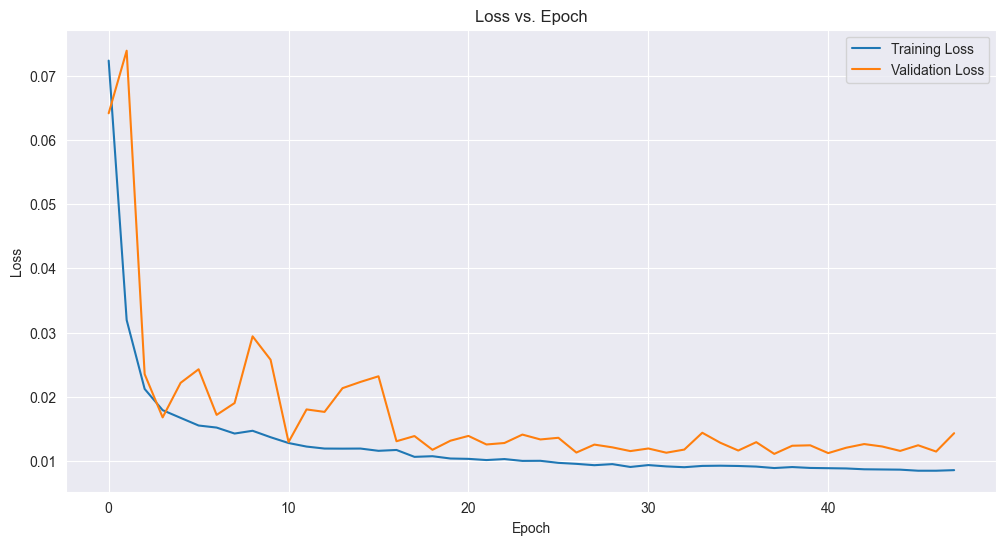

In [41]:
# Loss plot
plt.figure(figsize=(12, 6)) 
plt.plot(train_losses, label='Training Loss')  
plt.plot(val_losses, label='Validation Loss')  
plt.title('Loss vs. Epoch') 
plt.ylabel('Loss') 
plt.xlabel('Epoch')  
plt.legend() 
plt.grid(True)  
plt.show()  #

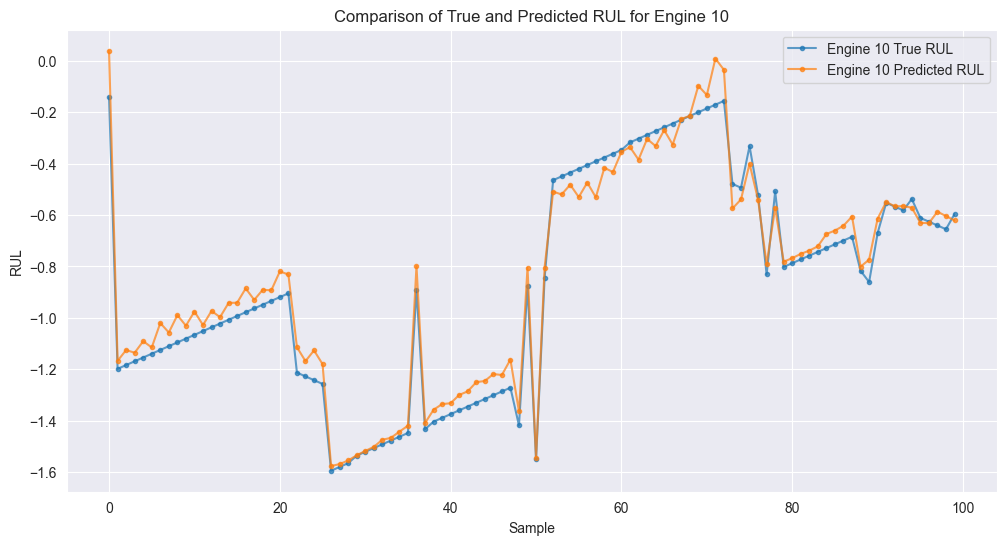

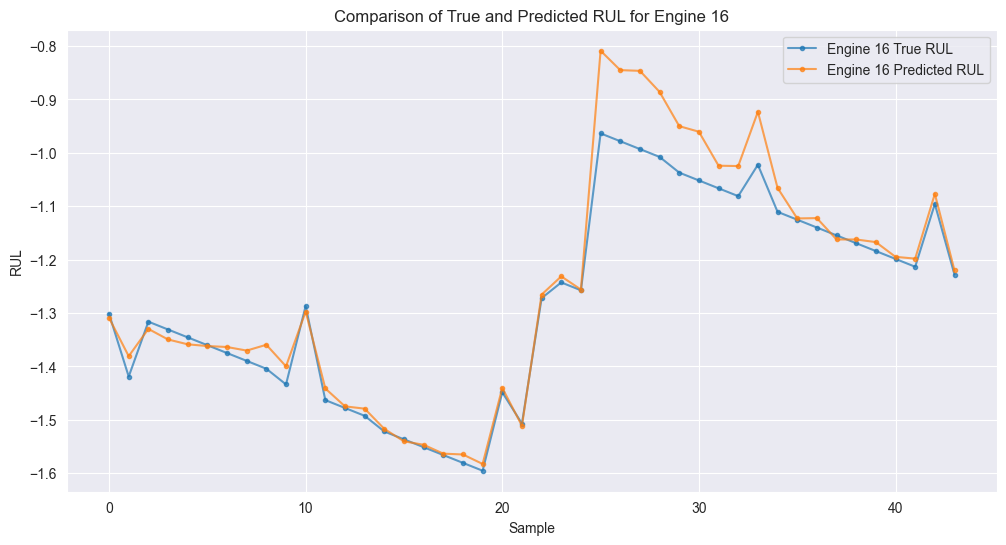

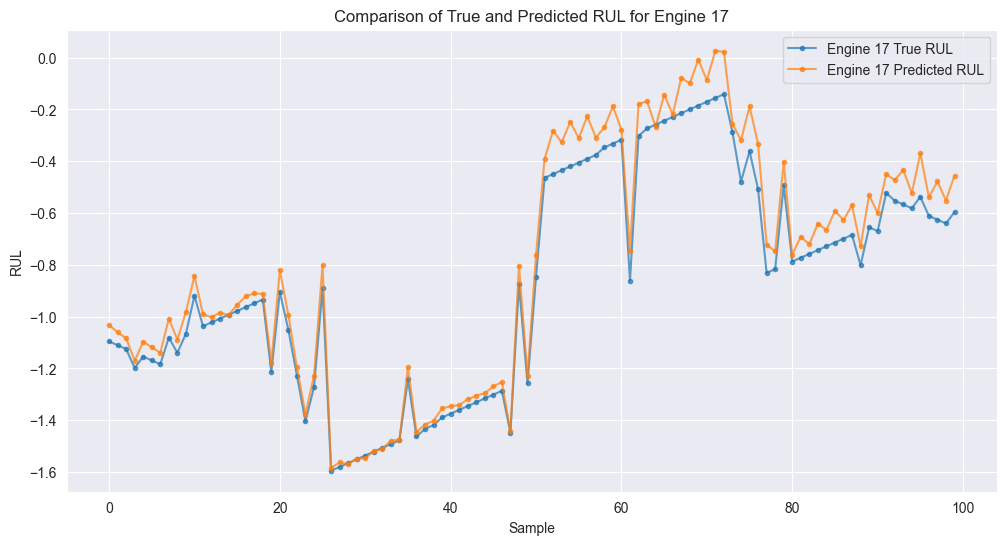

In [42]:
sample_engines = last_predictions['engine'][:3]

# Plot true and predicted RUL values for selected engines
for engine in sample_engines:
    plt.figure(figsize=(12, 6))
    temp = results[results['engine'] == engine]
    plt.plot(temp['y_true'].values, label=f'Engine {engine} True RUL', marker='.', alpha=0.7)
    plt.plot(temp['y_pred'].values, label=f'Engine {engine} Predicted RUL', marker='.', alpha=0.7)
    plt.xlabel('Sample')
    plt.ylabel('RUL')
    plt.title(f'Comparison of True and Predicted RUL for Engine {engine}')
    plt.legend()
    plt.show()

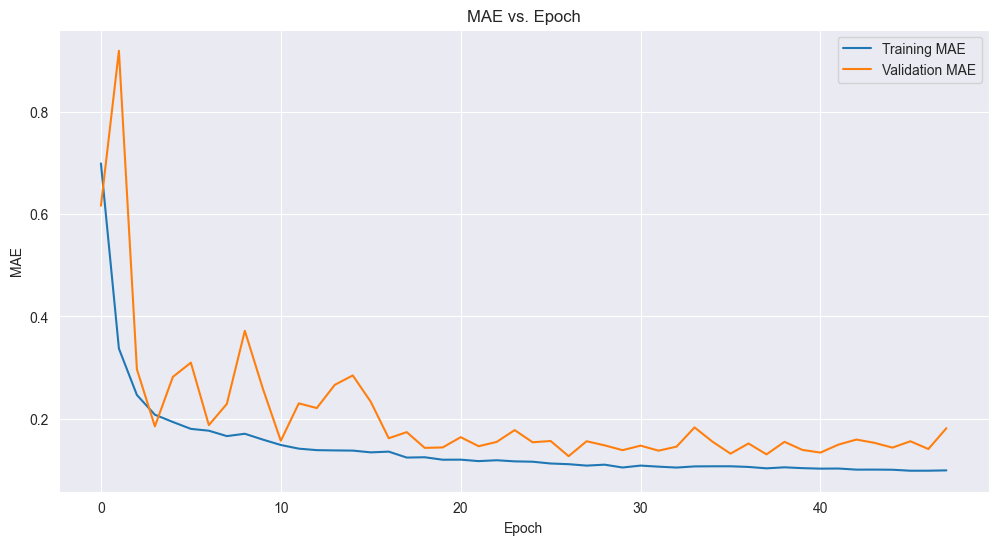

In [43]:
# MAE plot
plt.figure(figsize=(12, 6))  
plt.plot(train_mae, label='Training MAE')  
plt.plot(val_mae, label='Validation MAE')  
plt.title('MAE vs. Epoch')
plt.ylabel('MAE')
plt.xlabel('Epoch') 
plt.legend()  
plt.grid(True)  
plt.show()  

In [44]:
# Check maximum RUL values
print('Max true RUL:', last_predictions['y_true_unscaled'].max()) 
print('Max predicted RUL:', last_predictions['y_pred_unscaled'].max())  

Max true RUL: 109.0
Max predicted RUL: 100.114395


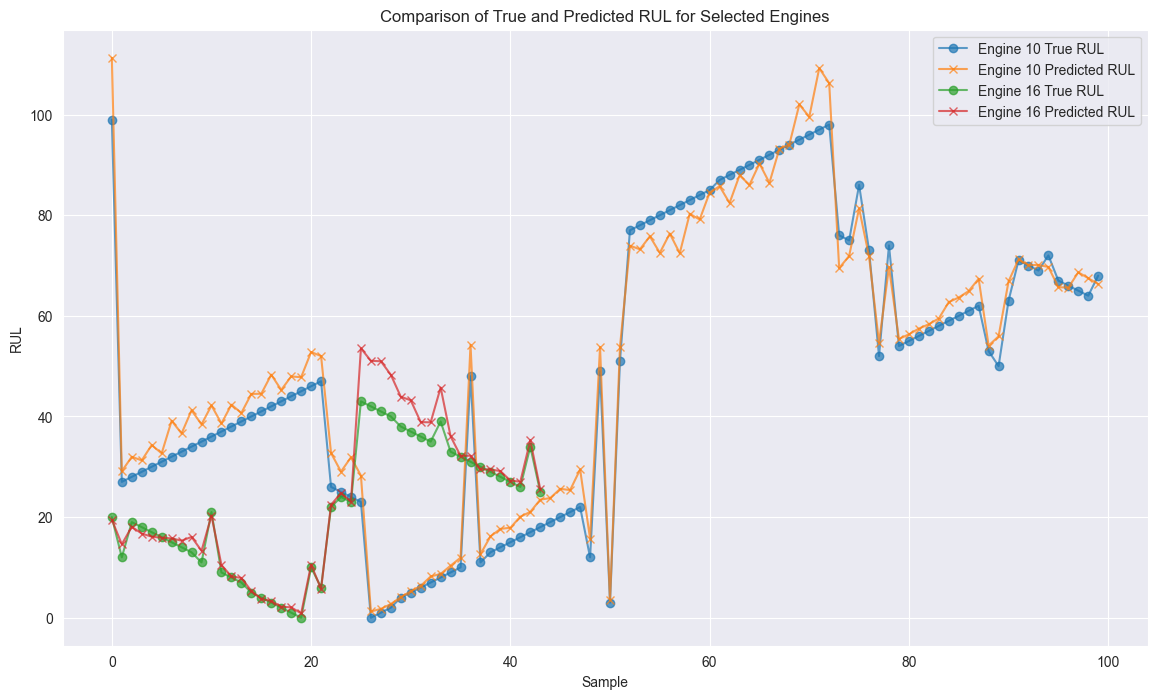

In [45]:
# Select engines for detailed analysis
sample_engines = last_predictions['engine'].unique()[:2]  
sample_results = results[results['engine'].isin(sample_engines)]  

# Plot true and predicted RUL values for selected engines
plt.figure(figsize=(14, 8))  
for engine in sample_engines:
    temp = results[results['engine'] == engine] 
    plt.plot(range(len(temp)), temp['y_true_unscaled'].values,
             label=f'Engine {engine} True RUL', marker='o', alpha=0.7)  
    plt.plot(range(len(temp)), temp['y_pred_unscaled'].values,
             label=f'Engine {engine} Predicted RUL', marker='x', alpha=0.7) 
plt.xlabel('Sample') 
plt.ylabel('RUL')  
plt.title('Comparison of True and Predicted RUL for Selected Engines')
plt.legend() 
plt.grid(True) 
plt.show() 

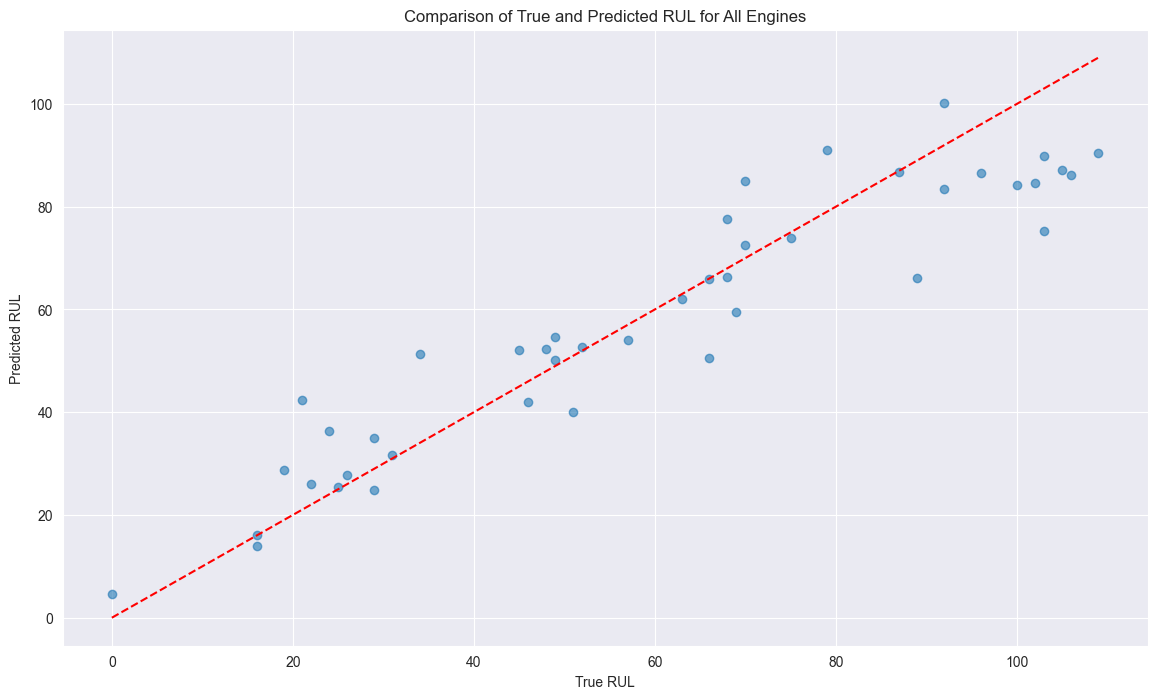

In [46]:
# Plot true and predicted RUL values for all engines
plt.figure(figsize=(14, 8)) 
plt.scatter(last_predictions['y_true_unscaled'], last_predictions['y_pred_unscaled'],
            alpha=0.6)  
plt.plot([0, last_predictions['y_true_unscaled'].max()],
         [0, last_predictions['y_true_unscaled'].max()], 'r--')  
plt.xlabel('True RUL') 
plt.ylabel('Predicted RUL') 
plt.title('Comparison of True and Predicted RUL for All Engines')
plt.grid(True) 
plt.show()

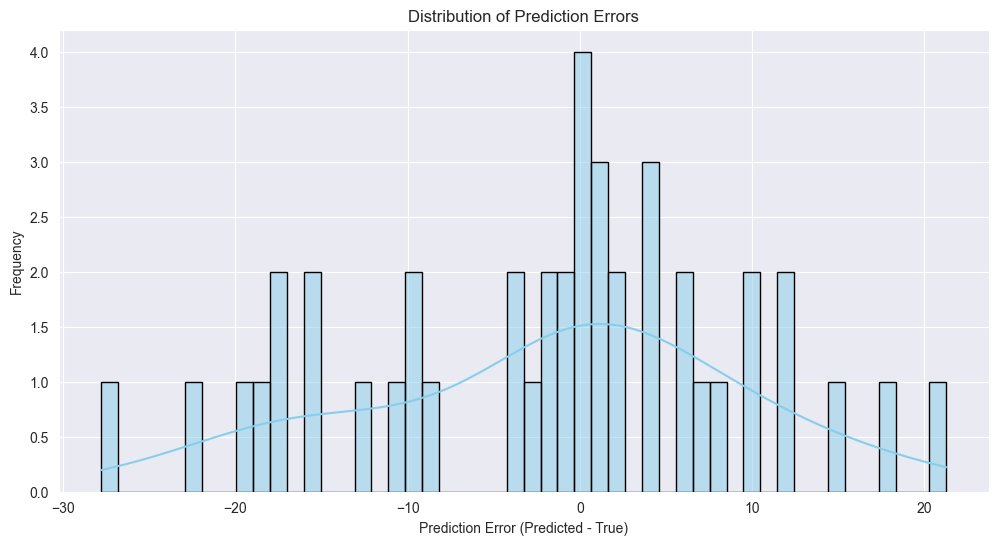

In [47]:
# Calculate prediction error
error = last_predictions['y_pred_unscaled'].values - last_predictions['y_true_unscaled'].values  

# Histogram of error distribution
plt.figure(figsize=(12, 6)) 
sns.histplot(error, bins=50, kde=True, color='skyblue', edgecolor='k') 
plt.title('Distribution of Prediction Errors') 
plt.xlabel('Prediction Error (Predicted - True)')  
plt.ylabel('Frequency') 
plt.grid(True) 
plt.show()  

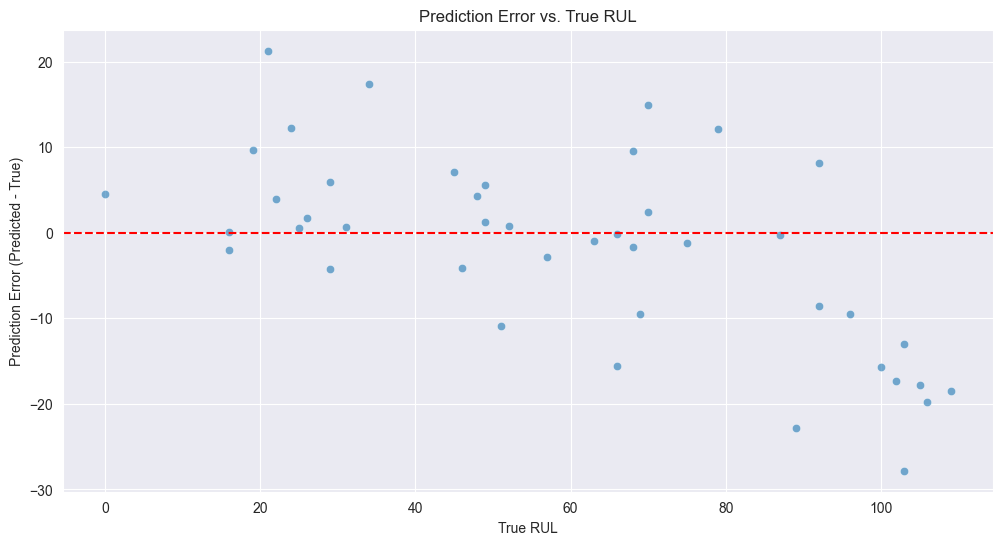

In [48]:
# Plot error vs. true RUL
plt.figure(figsize=(12, 6))
sns.scatterplot(x=last_predictions['y_true_unscaled'], y=error, alpha=0.6) 
plt.axhline(0, color='red', linestyle='--') 
plt.xlabel('True RUL')
plt.ylabel('Prediction Error (Predicted - True)') 
plt.title('Prediction Error vs. True RUL')  
plt.grid(True) 
plt.show() 

In [49]:
def smape(y_true, y_pred):
    """
    Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) 

smape_value = smape(last_predictions['y_true_unscaled'].values,
                    last_predictions['y_pred_unscaled'].values)

print('Validation SMAPE:', smape_value)

Validation SMAPE: 19.41134430641352


In [50]:
# Output final losses for training and validation sets
final_train_loss = train_losses[-1]  
final_val_loss = val_losses[-1] 
print(f'Final Training Loss: {final_train_loss:.4f}') 
print(f'Final Validation Loss: {final_val_loss:.4f}')

# Analyze difference between training and validation loss
difference = final_train_loss - final_val_loss  
print(f'Difference between training and validation loss: {difference:.4f}')  

Final Training Loss: 0.0086
Final Validation Loss: 0.0143
Difference between training and validation loss: -0.0058


Generated sequences for test set: 435
Dataset and data loader for test set created.
Best model loaded and ready for prediction on the test set.
Collected predictions on test set: 435
Predictions for final_test.txt saved in 'final_test_predictions.csv'.


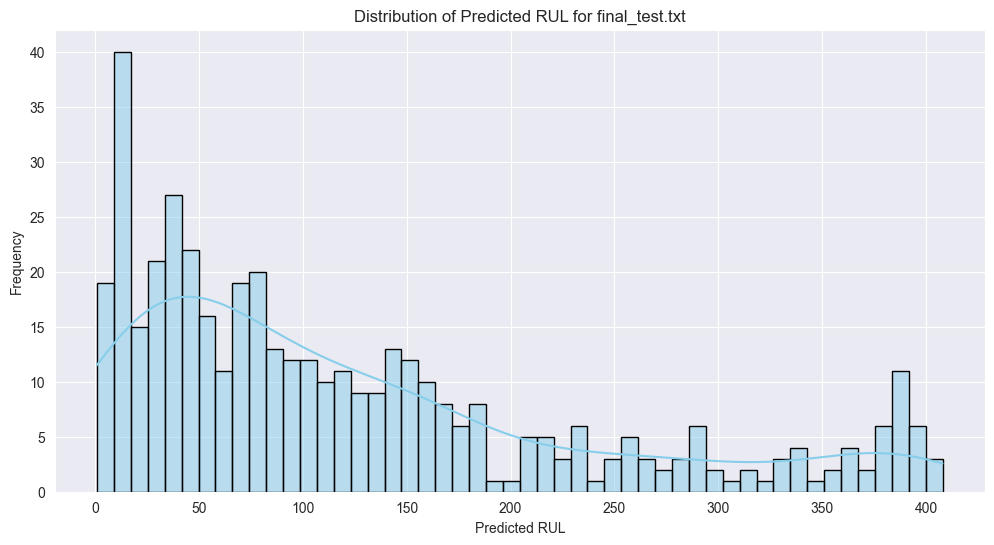

In [51]:
# Generation from file

# Load saved scalers for features and target variable
scaler_X = joblib.load('model_scalers/scaler_X.pkl') 
scaler_Y = joblib.load('model_scalers/scaler_Y.pkl') 

# Load test data from 'final_test.txt'
test_df = pd.read_csv('dataset/final_test.txt', sep=' ', header=None) 
test_df.dropna(axis=1, inplace=True) 

# Assign column names to test
test_df.columns = columns 

# Preprocess test data
test_df[feature_cols] = scaler_X.transform(test_df[feature_cols])  

# Generate sequences for test data
# Initialize lists to store sequences, masks, and engine numbers
seq_array_test = [] 
mask_array_test = []  
engine_test = []

# Iterate over each unique engine in the test data
for id in test_df['unit_number'].unique():
    id_df = test_df[test_df['unit_number'] == id]  
    data_array = id_df[feature_cols].values  
    num_elements = data_array.shape[0]  

    if num_elements >= SEQUENCE_LENGTH:
        # If sufficient cycles are available to form a full sequence
        seq = data_array[-SEQUENCE_LENGTH:, :]  
        mask = np.ones(SEQUENCE_LENGTH, dtype=np.float32)  
    else:
        # If cycles are less than SEQUENCE_LENGTH, pad the sequence with zeros (padding)
        pad_length = SEQUENCE_LENGTH - num_elements  
        seq = np.pad(data_array, ((pad_length, 0), (0, 0)), 'constant', constant_values=0)  
        # Create mask with zeros for padding and ones for real data
        mask = np.concatenate([np.zeros(pad_length, dtype=np.float32), np.ones(num_elements, dtype=np.float32)])  

    seq_array_test.append(seq) 
    mask_array_test.append(mask)  
    engine_test.append(id) 

# Convert lists to numpy arrays for further processing
seq_array_test = np.array(seq_array_test) 
mask_array_test = np.array(mask_array_test).astype(np.float32)  
engine_test = np.array(engine_test) 

print(f"Generated sequences for test set: {len(seq_array_test)}")


# Create dataset and data loader for test set
class TurbofanTestDataset(Dataset):
    def __init__(self, sequences, masks, engines):
        self.sequences = sequences 
        self.masks = masks 
        self.engines = engines  

    def __len__(self):
        return len(self.sequences) 

    def __getitem__(self, idx):
        # Get sequence, mask, and engine number by index
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)  
        mask = torch.tensor(self.masks[idx], dtype=torch.float32) 
        engine = self.engines[idx]  
        return sequence, mask, engine 


# Create an instance of the dataset with test data
test_dataset = TurbofanTestDataset(seq_array_test, mask_array_test, engine_test)

# Create data loader for test set
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=False)  

print("Dataset and data loader for test set created.")

# Initialize model for testing
# It is assumed that the TurbofanModel class has already been defined earlier and does not require redefinition
model_test = TurbofanModel(
    input_size=INPUT_SIZE, 
    dropout=DROPOUT, 
    lstm_hidden_size1=LSTM_HIDDEN_SIZE1,  
    lstm_hidden_size2=LSTM_HIDDEN_SIZE2,
    lstm_num_layers=LSTM_NUM_LAYERS 
).to(device) 

# Load saved weights of the trained model
model_test.load_state_dict(torch.load(MODEL_NAME, map_location=device)) 
model_test.eval()  

print("Best model loaded and ready for prediction on the test set.") 

# Predict RUL on test data
y_pred_test = []  
engine_test_list = []  

with torch.no_grad():
    for X_batch, mask_batch, engine_batch in test_loader:
        X_batch = X_batch.to(device) 
        mask_batch = mask_batch.to(device) 
        outputs = model_test(X_batch, mask_batch)  
        y_pred_test.extend(outputs.cpu().numpy())  
        engine_test_list.extend(engine_batch.numpy()) 

# Convert lists to numpy arrays for further analysis
y_pred_test = np.array(y_pred_test)
engine_test_list = np.array(engine_test_list)

print(f"Collected predictions on test set: {len(y_pred_test)}")  

# Form final predictions for each engine
# Create DataFrame for convenient data handling
results_test = pd.DataFrame({
    'unit_number': engine_test_list,
    'y_pred': y_pred_test  
})

# Inverse transform predicted RUL values to original scale
results_test['RUL'] = scaler_Y.inverse_transform(results_test['y_pred'].values.reshape(-1, 1)).reshape(-1) 

# Set negative RUL values to zero, since RUL cannot be negative
results_test['RUL'] = results_test['RUL'].clip(lower=0)  

# Save predictions to CSV file without indices
results_test.to_csv('final_test_predictions.csv', index=False)  

print("Predictions for final_test.txt saved in 'final_test_predictions.csv'.")

# Visualize distribution of predicted RUL values for the test set
plt.figure(figsize=(12, 6)) 
sns.histplot(results_test['RUL'], bins=50, kde=True, color='skyblue', edgecolor='k') 
plt.title('Distribution of Predicted RUL for final_test.txt') 
plt.xlabel('Predicted RUL')  
plt.ylabel('Frequency') 
plt.grid(True)  
plt.show()  